<a href="https://colab.research.google.com/github/swardiantara/fp-kk-2021/blob/main/FP_KK_CoNLL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount the G Drive to access the data set
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/CoNLL/train.txt'
dataset = []
with open(dataset_path) as fp:
  sentence = 1
  lines = fp.readlines()
  for line in lines:
    if (not line in ["\n", "\r\n"]):
      line_arr = line.split(' ')
      word = line_arr[0]
      tag = line_arr[3].strip()
      dataset.append([sentence, word, tag])
    else:
      sentence += 1

In [4]:
import pandas as pd
import numpy as np

In [5]:
datasetdf = pd.DataFrame(np.array(dataset), columns=["sentence #", "word", "tag"])

In [6]:
datasetdf

,sentence #,word,tag
0,1,-DOCSTART-,O
1,2,EU,B-ORG
2,2,rejects,O
3,2,German,B-MISC
4,2,call,O
...,...,...,...
204562,14986,three,O
204563,14987,Swansea,B-ORG
204564,14987,1,O
204565,14987,Lincoln,B-ORG


In [8]:
datasetdf['tag'].value_counts()

O         170524
B-LOC       7140
B-PER       6600
B-ORG       6321
I-PER       4528
I-ORG       3704
B-MISC      3438
I-LOC       1157
I-MISC      1155
Name: tag, dtype: int64

In [26]:
def computeRatioAwal(dataset):
  negative = dataset.apply(lambda x : True if x['tag'] == "O" else False, axis = 1)
  num_negative = len(negative[negative == True].index)
  num_positive = len(negative[negative == False].index)
  return num_negative / num_positive 

In [27]:
print(computeRatioAwal(datasetdf))

5.0090767558675795


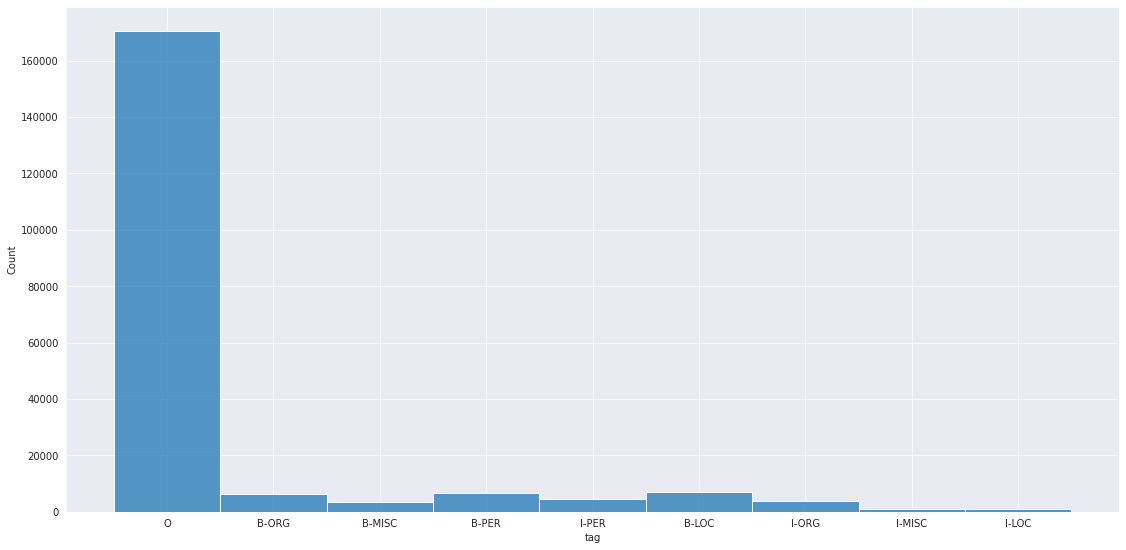

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (16,8))
sns.set_style('darkgrid')
sns.histplot(datasetdf['tag'])
plt.tight_layout(pad=2)
plt.show()

Preprocessing

In [9]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['word'].to_list()))
    else:
        vocab = list(set(data['tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok
token2idx, idx2token = get_dict_map(datasetdf, 'token')
tag2idx, idx2tag = get_dict_map(datasetdf, 'tag')

In [11]:
datasetdf['word_idx'] = datasetdf['word'].map(token2idx)
datasetdf['tag_idx'] = datasetdf['tag'].map(tag2idx)
datasetdf_fillna = datasetdf.fillna(method='ffill', axis=0)
# Groupby and collect columns
datasetdf_group = datasetdf_fillna.groupby(
['sentence #'],as_index=False
)['word', 'tag', 'word_idx', 'tag_idx'].agg(lambda x: list(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


In [12]:
datasetdf_group

,sentence #,word,tag,word_idx,tag_idx
0,1,[-DOCSTART-],[O],[11715],[8]
1,10,"[Fischler, proposed, EU-wide, measures, after,...","[B-PER, O, B-MISC, O, O, O, O, B-LOC, O, B-LOC...","[20215, 10963, 19004, 19997, 7087, 19751, 1001...","[0, 8, 7, 8, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, ..."
2,100,"[Port, conditions, update, -, Syria, -, Lloyds...","[O, O, O, O, B-LOC, O, B-ORG, I-ORG, O]","[19933, 9645, 22595, 2099, 18058, 2099, 7525, ...","[8, 8, 8, 8, 3, 8, 1, 5, 8]"
3,1000,[-DOCSTART-],[O],[11715],[8]
4,10000,"[*, Reinsurance, group, Scor, gained, 2.1, per...","[O, O, O, B-ORG, O, O, O, O, O, O, O, O, O, B-...","[3853, 18982, 14492, 16966, 13905, 12873, 5556...","[8, 8, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, ..."
...,...,...,...,...,...
14982,9995,"[Index, heavyweights, Elf, and, Rhone, Poulenc...","[O, O, B-ORG, O, B-ORG, I-ORG, O, O, O, O, O, ...","[20553, 21361, 1263, 9531, 8728, 2312, 6471, 4...","[8, 8, 1, 8, 1, 5, 8, 8, 8, 8, 8, 8, 3, 8, 8, ..."
14983,9996,"["", People, are, morose, and, it, 's, not, the...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[12567, 13912, 15541, 13643, 9531, 18620, 4105...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
14984,9997,"[*, UIC, ,, part, of, insurer, GAN, ,, slid, 1...","[O, B-ORG, O, O, O, O, B-ORG, O, O, O, O, O, O...","[3853, 21800, 15031, 20534, 6709, 18199, 4679,...","[8, 1, 8, 8, 8, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, ..."
14985,9998,"[Markets, were, disappointed, by, a, recapital...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[23193, 20891, 20388, 8678, 17285, 4551, 6709,...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."


In [13]:
import numpy as np 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['word'].to_list())))
    n_tag = len(list(set(data['tag'].to_list())))

    #Pad tokens (X var)    
    tokens = data_group['word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_, tags_, test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

In [14]:
train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(datasetdf_group, datasetdf)
train_tags = np.array(train_tags)
val_tags = np.array(val_tags)
test_tags = np.array(test_tags)
print('train_tags: ',train_tags.shape,'val_tags: ',val_tags.shape,'test_tags: ',test_tags.shape)

train_tokens length: 10116 
train_tokens length: 10116 
test_tokens length: 1499 
test_tags: 1499 
val_tokens: 3372 
val_tags: 3372
train_tags:  (10116, 113, 9) val_tags:  (3372, 113, 9) test_tags:  (1499, 113, 9)


In [15]:
from sklearn.utils import class_weight

train_temp_tags = np.ravel(np.argmax(train_tags, axis=-1))
print(len(train_temp_tags))

class_weights = class_weight.compute_class_weight(
    class_weight ='balanced', 
    classes = np.unique(train_temp_tags), 
    y = train_temp_tags
    )
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

train_label = np.argmax(train_tags, axis=-1)
print(train_tokens.shape)
print(train_label.shape)

1143108
{0: 27.939287285525737, 1: 29.97687042718905, 2: 40.82674381227901, 3: 25.995088006549324, 4: 157.38785625774474, 5: 50.4616607071911, 6: 157.58312655086849, 7: 54.34830979888746, 8: 0.11341764736873594}
(10116, 113)
(10116, 113)


Create and Train Model (BiLSTM)

In [16]:
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input
from tensorflow.keras.utils import plot_model
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [17]:
input_dim = len(list(set(datasetdf['word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in datasetdf_group['word_idx'].tolist()])
n_tags = len(tag2idx)

In [18]:
def get_bilstm_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    model.add((Dense(n_tags, activation="softmax")))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [20]:
maj_index = tag2idx['O']

''' Change it More for Better Fine-Tuning '''

class_weight_dict[maj_index] = 28.5277954105731576 
print(class_weight_dict)
sample_weights = np.ones(shape=(len(train_label), train_label.shape[-1]))
for i in range(17):
    sample_weights[train_label == i] = class_weight_dict.get(i)
print(sample_weights.shape)

{0: 27.939287285525737, 1: 29.97687042718905, 2: 40.82674381227901, 3: 25.995088006549324, 4: 157.38785625774474, 5: 50.4616607071911, 6: 157.58312655086849, 7: 54.34830979888746, 8: 28.52779541057316}
(10116, 113)


In [21]:
nlp_model = get_bilstm_lstm_model()
plot_model(nlp_model)
his = nlp_model.fit(train_tokens, train_label , batch_size = 64, epochs=5, validation_split=0.2, sample_weight = sample_weights) 


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 113, 64)           1512000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 113, 128)         66048     
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 113, 64)           49408     
                                                                 
 dense_1 (Dense)             (None, 113, 9)            585       
                                                                 
Total params: 1,628,041
Trainable params: 1,628,041
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
127/127 [==============================] - 100s 718ms/step - loss: 8.0451 - accuracy: 0.9720 - val_l

NameError: ignored

In [22]:
import tensorflow as tf
tf.keras.models.save_model(nlp_model, filepath  = "/content/drive/MyDrive/Colab Notebooks/ner-kk/bilstm_CoNLL_baseline.h5")

Model Evaluation

In [23]:
nlp_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ner-kk/bilstm_CoNLL_baseline.h5')

y_test = np.argmax(test_tags, axis=-1)
print(test_tokens.shape,y_test.shape)
nlp_model.evaluate(test_tokens, y_test)

(1499, 113) (1499, 113)
47/47 [==============================] - 4s 63ms/step - loss: 0.0403 - accuracy: 0.9868


[0.040282320231199265, 0.9867699146270752]

In [29]:
def predict(seed):
    query  = test_tokens[seed]
    query_text = []
    for i in query.tolist():
        query_text.append(idx2token.get(i))
    print('Query_Text: ',' '.join(query_text[:10]))

    ans = y_test[seed]
    ans_text = []
    for i in ans.tolist():
        ans_text.append(idx2tag.get(i))
    print('Tag_Text: ',' '.join(ans_text[:10]))

    query = query.reshape(1,-1)
    pred = nlp_model.predict(query)
    pred = np.ravel(np.argmax(pred, axis=-1))
    print('Query: ',query.shape,'Prediction: ',pred.shape)

    pred_list = []
    for i in pred.tolist():
        pred_list.append(idx2tag.get(i))
    print('Prediction_Text: ',' '.join(pred_list[:10])) 
    print()
    print('--- Better-Representation---')
    print()
    rep_qr = []
    for q, r_tag in zip(query_text[:10], ans_text[:10]):
        rep_qr.append(q)
        rep_qr.append('['+r_tag+']')
    print('Actual_NER: ',' '.join(rep_qr),'....')
    print()
    rep_qp = []
    for q, r_tag in zip(query_text[:10], pred_list[:10]):
        rep_qp.append(q)
        rep_qp.append('['+r_tag+']')
    print('--'*70)
    print()
    print('Predicted_NER: ',' '.join(rep_qp),'....')

In [33]:
seed = 11
predict(seed)

Query_Text:  In 1993 , she fell in Rome and broke three
Tag_Text:  O O O O O O B-LOC O O O
Query:  (1, 113) Prediction:  (113,)
Prediction_Text:  O O O O O O B-PER O O O

--- Better-Representation---

Actual_NER:  In [O] 1993 [O] , [O] she [O] fell [O] in [O] Rome [B-LOC] and [O] broke [O] three [O] ....

--------------------------------------------------------------------------------------------------------------------------------------------

Predicted_NER:  In [O] 1993 [O] , [O] she [O] fell [O] in [O] Rome [B-PER] and [O] broke [O] three [O] ....
